In [2]:
import warnings  
from data_loading import MVTecDataset, _CLASSNAMES, _CLASSNAMES_1, _CLASSNAMES_2, _CLASSNAMES_3, _CLASSNAMES_4
from patchcore_model import PatchCore
from utils import print_results

from typing import List
import torch
import random
import numpy as np
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

warnings.filterwarnings("ignore")

ALL_CLASSES = _CLASSNAMES
BATCH_CLASSES_1 = _CLASSNAMES_1
BATCH_CLASSES_2 = _CLASSNAMES_2 
BATCH_CLASSES_3 = _CLASSNAMES_3
BATCH_CLASSES_4 = _CLASSNAMES_4
test = ["bottle"]


The model is runing on the bottle dataset ...
Beginning of the fit method...
Beginning of the coreset subsampling reduction...
   Fitting random projections. Start dim = torch.Size([163856, 1536]).
   DONE.                 Transformed dim = torch.Size([163856, 296]).
End of the coreset subsampling reduction
Sklearn roc_auc metric computation loading ...


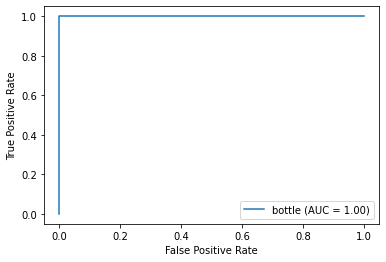

Here are the test results on the dataset bottle
ROC_AUC metric : 1.0

The model is runing on the cable dataset ...
The dataset cable is not already present in C:\mvtec_anomaly_detection . Downloading cable ...
Extracting the compressed folder cable .tar.xz....
Download of cable in C:\mvtec_anomaly_detection Complete.
Beginning of the fit method...
Beginning of the coreset subsampling reduction...
   Fitting random projections. Start dim = torch.Size([175616, 1536]).
   DONE.                 Transformed dim = torch.Size([175616, 298]).
End of the coreset subsampling reduction
Sklearn roc_auc metric computation loading ...


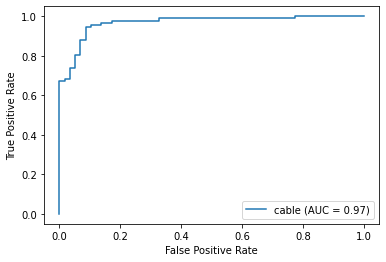

Here are the test results on the dataset cable
ROC_AUC metric : 0.9672038980509745

The model is runing on the capsule dataset ...
The dataset capsule is not already present in C:\mvtec_anomaly_detection . Downloading capsule ...
Extracting the compressed folder capsule .tar.xz....
Download of capsule in C:\mvtec_anomaly_detection Complete.
Beginning of the fit method...
Beginning of the coreset subsampling reduction...
   Fitting random projections. Start dim = torch.Size([171696, 1536]).
   DONE.                 Transformed dim = torch.Size([171696, 297]).
End of the coreset subsampling reduction
Sklearn roc_auc metric computation loading ...


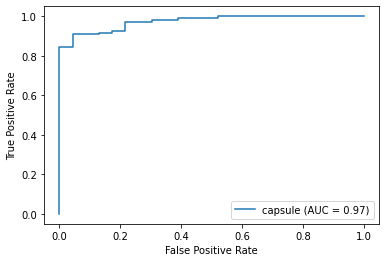

Here are the test results on the dataset capsule
ROC_AUC metric : 0.973274830474671

The model is runing on the carpet dataset ...
The dataset carpet is not already present in C:\mvtec_anomaly_detection . Downloading carpet ...
Extracting the compressed folder carpet .tar.xz....
Download of carpet in C:\mvtec_anomaly_detection Complete.
Beginning of the fit method...
Beginning of the coreset subsampling reduction...
   Fitting random projections. Start dim = torch.Size([219520, 1536]).
   DONE.                 Transformed dim = torch.Size([219520, 303]).
End of the coreset subsampling reduction
Sklearn roc_auc metric computation loading ...


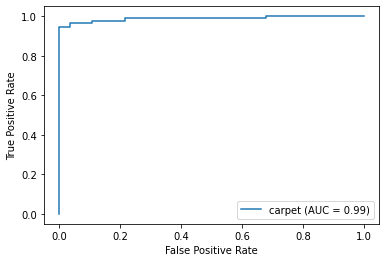

Here are the test results on the dataset carpet
ROC_AUC metric : 0.9879614767255216


"After 4 iterations performed on different datasets, here is the final average results obtained :{'per_class_results': {'bottle': [1.0], 'cable': [0.9672038980509745], 'capsule': [0.973274830474671], 'carpet': [0.9879614767255216]}, 'average image rocauc': 0.9821100513127918, 'model parameters': {'backbone_name': 'wideresnet50', 'out_indices': (2, 3), 'f_coreset': 0.25, 'n_reweight': 3}}"

In [3]:
def create_model(model_name: str):
    if model_name == "PatchCore":
        return PatchCore(f_coreset=.25, backbone_name="wideresnet50")
    else:
        raise ValueError(f"The model {model_name} do not exists or is not avaiable here")

def train_model(model, train_dataset):
    model.fit(train_dataset)

def evaluate_model(model, test_dataset, cls):
    return model.evaluate(test_dataset, cls = cls)

# Main method that will allow running the program
def run_model(model_name: str, classes: List):

    results = {}


    nb_datasets = len(classes)

    # This function iterates over the different datasets to train the model on it, test it with the test images and evaluate the performance
    for cls in classes:

        # Creation of the model
        model = create_model(model_name)
        print(f"\nThe model is runing on the {cls} dataset ...")

        # Load of the data related to the current dataset
        train_ds, test_ds = MVTecDataset(cls).get_dataloaders()

        # Train the model using the training data
        train_model(model, train_ds)

        # Use the test data to apply the trained model on it, try to classify it and evaluate the performance
        image_rocauc = evaluate_model(model, test_ds, cls)
        
        print("Here are the test results on the dataset", cls)
        print("ROC_AUC metric :", image_rocauc)

        results[cls] = [float(image_rocauc)]
        image_results = [v[0] for _, v in results.items()]

        # Compute the average score based on the scores obtained on the dataset tested
        average_image_roc_auc = sum(image_results)/len(image_results)


        total_results = {
            "per_class_results": results,
            "average image rocauc": average_image_roc_auc,
            "model parameters": model.get_parameters(),
        }

    return "After " + str(nb_datasets) + " iterations performed on different datasets, here is the final average results obtained :" + str(total_results)


run_model("PatchCore", BATCH_CLASSES_1)

-- **SUMMARY OF THE OBTAINED RESULTS** -- 

Several results are displayed below and represent the roc_auc score computed for each dataset. The differents columns represent the *f_coreset* value used this the execution of the PatchCore algorithm. The first one corresponds to a value of **0.1**, which **10% of the memory bank** is kept during the **subsampling part**. The second one corresponds to a value of **0.25**, representing **25% of the memory bank**. 

```
ROC_AUC score res| f_coreset :      0.1                0.25
- bottle dataset              1.0                  1.0
- cable dataset               0.9565217391304348   0.9636431784107946
- capsule dataset             0.9792580773833267   0.9748703629836457
- carpet dataset              0.9851524879614767   0.985553772070626
- grid dataset                0.9598997493734336   0.9573934837092732
- leather dataset             1.0                  1.0
- metal_nut dataset           0.9828934506353861   0.9853372434017595
- pill dataset                0.9399890889252592   0.92253136933988
- screw dataset               0.9204755072760812   0.9020291043246567
- tile dataset                0.9985569985569986   0.998917748917749
- toothbrush dataset          0.9222222222222223   0.9222222222222223
- transistor dataset          0.9954166666666666   0.9937499999999999
- wood dataset                0.9885964912280701   0.9842105263157894
- zipper dataset              0.9634978991596639   0.9663865546218487
```

Now let's retrieve these values to perform some statistic and visualization.

-- **AVERAGE SCORE**--

In [4]:
# List of the roc_auc score obtained with f_coreset = 0.1
results_fcor_0_1 = [1.0, 0.9565217391304348, 0.9792580773833267, 0.9851524879614767, 0.9598997493734336, 1.0, 0.9828934506353861,
           0.9399890889252592, 0.9204755072760812, 0.9985569985569986, 0.9222222222222223, 0.9954166666666666, 0.9885964912280701, 0.963497899159663]

# List of the roc_auc score obtained with f_coreset = 0.25
results_fcor_0_25 = [1.0, 0.9636431784107946, 0.9748703629836457, 0.985553772070626, 0.9573934837092732, 1.0, 0.9853372434017595, 
           0.92253136933988, 0.9020291043246567, 0.998917748917749, 0.9222222222222223, 0.9937499999999999, 0.9842105263157894, 0.9663865546218487]

# List of the names of the datasets 
labels = ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']

# Average score per list 
average_image_roc_auc_1 = sum(results_fcor_0_1)/len(results_fcor_0_1)
average_image_roc_auc_2 = sum(results_fcor_0_25)/len(results_fcor_0_25)
print("Average score over all the dataset tested with f_coreset = 0.1: ", round(average_image_roc_auc_1, 3))
print("Average score over all the datasets tested with f_coreset = 0.25:", round(average_image_roc_auc_2, 3))

Average score over all the dataset tested with f_coreset = 0.1:  0.971
Average score over all the datasets tested with f_coreset = 0.25: 0.968


-- **VISUALIZATION** -- 

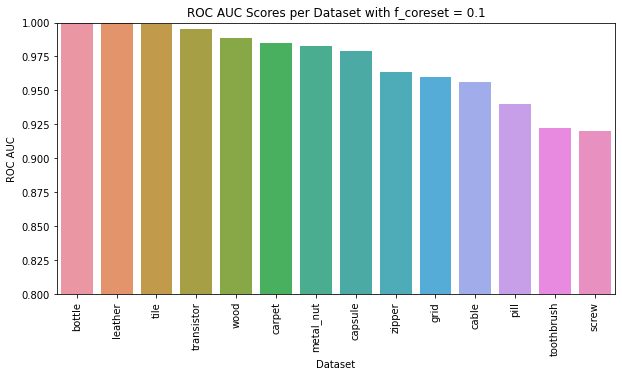

In [8]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = {'ROC AUC': results_fcor_0_1, 'Dataset': labels}
df = pd.DataFrame(data)
df = df.sort_values('ROC AUC', ascending = False)
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
plt.ylim(0.8, 1.0)
sns.barplot(x = 'Dataset', y = 'ROC AUC', data = df)
plt.title('ROC AUC Scores per Dataset with f_coreset = 0.1')
plt.show()

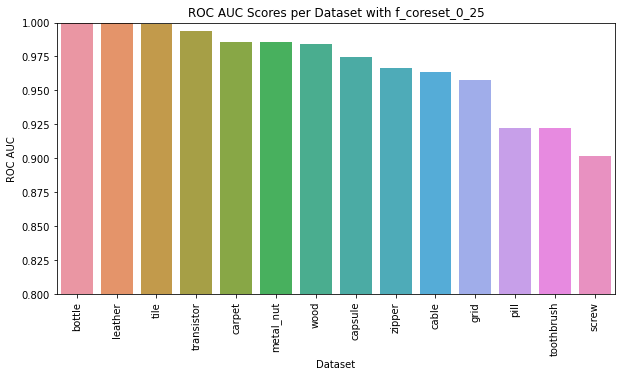

In [12]:
data = {'ROC AUC': results_fcor_0_25, 'Dataset': labels}
df = pd.DataFrame(data)
df = df.sort_values('ROC AUC', ascending = False)
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
plt.ylim(0.8, 1.0)
sns.barplot(x = 'Dataset', y = 'ROC AUC', data = df)
plt.title('ROC AUC Scores per Dataset with f_coreset_0_25')
plt.show()

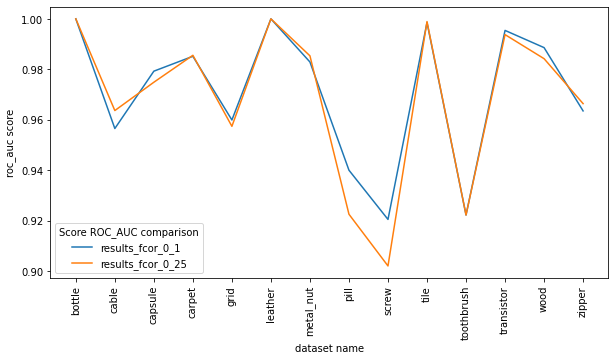

In [15]:
df = pd.DataFrame({'results_fcor_0_1' : results_fcor_0_1, 'results_fcor_0_25' : results_fcor_0_25, 'labels' : labels})
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.lineplot(x = 'labels', y = 'value', hue = 'variable', data = pd.melt(df, ['labels']))
plt.legend(title = 'Score ROC_AUC comparison')
plt.xlabel('dataset name')
plt.ylabel('roc_auc score')
plt.show()